In [25]:
# Activate cell with Y key to enable module imports if not running notebook within Docker
# Deactivate cell with R key

import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/raw/train.csv')
dfc = df.copy()

target = dfc.loc[:, 'TARGET_5Yrs':]
dfc_labeled = dfc.loc[:, 'GP':'TARGET_5Yrs']
dfc = dfc.loc[:, 'GP':'TOV']

In [44]:
from src.features.kpw_build_features import build
from sklearn.preprocessing import StandardScaler

dfc = build(dfc)

scaler = StandardScaler()
dfc = scaler.fit_transform(dfc)

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dfc, target, test_size=0.2, random_state=5)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

In [46]:
from sklearn.linear_model import LogisticRegression

#log_reg = LogisticRegression(max_iter=8_000)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train.values.ravel())

LogisticRegression()

In [47]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train.values.ravel())

KNeighborsClassifier()

In [48]:
from sklearn.ensemble import RandomForestClassifier

# Must use non-default hyperparameters to reduce overfitting
rfc = RandomForestClassifier(max_depth=5)
rfc.fit(X_train, y_train.values.ravel())

RandomForestClassifier(max_depth=5)

In [55]:
from sklearn.metrics import accuracy_score, mean_squared_error as mse, mean_absolute_error as mae
from src.models.eval_ratio_accuracy import ratioAccuracy

y_mean = y_train.mean()
y_base = np.full((len(y_train), 1), y_mean)
print('RMSE:' ,mse(y_train, y_base, squared=False))
print('MAE:', mae(y_train, y_base))
print('Base accuracy:', ratioAccuracy(y_train))

RMSE: 0.3715679022650535
MAE: 0.2761254119873047


0.72302734375

In [ ]:
from src.models.eval_model import eval_model

print('Logistic Regression:')
eval_model(log_reg, X_train, y_train, X_valid, y_valid)

print('K Nearest Neighbors:')
eval_model(knn, X_train, y_train, X_valid, y_valid)

print('Random Forest:')
eval_model(rfc, X_train, y_train, X_valid, y_valid)

In [50]:
from hyperopt import fmin, hp, STATUS_OK, tpe, Trials
from sklearn.model_selection import cross_val_score

In [41]:
log_reg_space = {
    'C' : hp.quniform('C', 0.01, 100, 0.05),
    'fit_intercept' : hp.choice('fit_intercept', [False, True]),
    'multi_class': hp.choice('multi_class', ['auto', 'ovr', 'multinomial']),
    'l1_ratio': hp.quniform('l1_ratio', 0.0, 1.0, 0.05)
}

def tune_log_reg(space):
    log_reg_hyperopt = LogisticRegression(
        penalty = 'elasticnet',
        C = space['C'],
        fit_intercept = space['fit_intercept'],
        solver = 'saga',
        max_iter = 10_000,
        multi_class = space['multi_class'],
        n_jobs = -1,
        l1_ratio = space['l1_ratio']
    )
    acc = cross_val_score(log_reg_hyperopt, X_train, y_train.values.ravel(), scoring="accuracy", cv=10).mean()
    return {"loss": -acc, "status": STATUS_OK}

log_reg_best = fmin(
    fn = tune_log_reg,
    space = log_reg_space,
    algo = tpe.suggest,
    max_evals = 50
)

print('Best Logistic Regression Elasticnet hyperparameter values:\n', log_reg_best)

100%|█████████████████████████████████████████████████████| 50/50 [06:36<00:00,  7.93s/trial, best loss: -0.8353515625]
Best Logistic Regression Elasticnet hyperparameter values:
 {'C': 1.4000000000000001, 'fit_intercept': 1, 'l1_ratio': 1.0, 'multi_class': 1}


In [42]:
knn_space = {
    'n_neighbors' : hp.quniform('n_neighbors', 1, 100, 1),
    'weights' : hp.choice('weights', ['uniform', 'distance']),
    'algorithm' : hp.choice('algorithm', ['ball_tree', 'kd_tree', 'brute']),
    'p' : hp.choice('p', [1, 2]),
}

def tune_knn(space):
    knn_hyperopt = KNeighborsClassifier(
        n_neighbors = int(space['n_neighbors']),
        weights = space['weights'],
        algorithm = space['algorithm'],
        p = space['p'],
        n_jobs = -1
    )
    acc = cross_val_score(knn_hyperopt, X_train, y_train.values.ravel(), scoring="accuracy", cv=10).mean()
    return {"loss": -acc, "status": STATUS_OK}

knn_best = fmin(
    fn = tune_knn,
    space = knn_space,
    algo = tpe.suggest,
    max_evals = 50
)

print('Best KNN hyperparameter values:\n', knn_best)

100%|██████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24trial/s, best loss: -0.835546875]
Best KNN hyperparameter values:
 {'algorithm': 2, 'n_neighbors': 42.0, 'p': 1, 'weights': 0}


In [22]:
rfc_space = {
    'n_estimators' : hp.quniform('n_estimators', 1, 10_000, 10),
    'criterion' : hp.choice('criterion', ['gini', 'entropy']),
    'max_depth' : hp.quniform('max_depth', 5, 100, 5),
    'max_features' : hp.choice('max_features', ['sqrt', 'log2', None])
}

def tune_rfc(space):
    rfc_hyperopt = RandomForestClassifier(
        n_estimators = int(space['n_estimators']),
        criterion = space['criterion'],
        max_depth = space['max_depth'],
        max_features = space['max_features'],
        n_jobs = -1
    )
    acc = cross_val_score(rfc_hyperopt, X_train, y_train.values.ravel(), scoring="accuracy", cv=10).mean()
    return {"loss": -acc, "status": STATUS_OK}

rfc_best = fmin(
    fn = tune_rfc,
    space = rfc_space,
    algo = tpe.suggest,
    max_evals = 50
)

print('Best RFC hyperparameter values:\n', rfc_best)

100%|███████████████████████████████████████████████████| 50/50 [1:24:14<00:00, 101.10s/trial, best loss: -0.835546875]
Best RFC hyperparameter values:
 {'criterion': 1, 'max_depth': 10.0, 'max_features': 2, 'n_estimators': 4230.0}


In [51]:
log_reg_l2_optimised = LogisticRegression(
    penalty = 'l2',
    C = 97.95,
    fit_intercept = True,
    solver = 'saga',
    max_iter = 10_000,
    multi_class = 'multinomial',
    n_jobs = -1
)

log_reg_l2_optimised.fit(X_train, y_train.values.ravel())

log_reg_elastic_optimised = LogisticRegression(
    penalty = 'elasticnet',
    C = 1.4,
    fit_intercept = True,
    solver = 'saga',
    max_iter = 10_000,
    multi_class = 'ovr',
    l1_ratio = 1.0,
    n_jobs = -1
)

log_reg_elastic_optimised.fit(X_train, y_train.values.ravel())


knn_optimised = KNeighborsClassifier(
    n_neighbors = 42,
    weights = 'uniform',
    algorithm = 'brute',
    p = 2,
    n_jobs = -1
)

knn_optimised.fit(X_train, y_train.values.ravel())

rfc_optimised = RandomForestClassifier(
    n_estimators = 4230,
    criterion = 'entropy',
    max_depth = 10,
    max_features = None,
    n_jobs = -1
)

rfc_optimised.fit(X_train, y_train.values.ravel())

RandomForestClassifier(criterion='entropy', max_depth=10, max_features=None,
                       n_estimators=4230, n_jobs=-1)

Logistic Regression L2 Tuned:


Logistic Regression Elastic Tuned:


K Nearest Neighbors Tuned:


Random Forest Tuned:


(RandomForestClassifier(criterion='entropy', max_depth=10, max_features=None,
                        n_estimators=4230, n_jobs=-1),
 0.9807166218459115,
 0.6721595730290099)

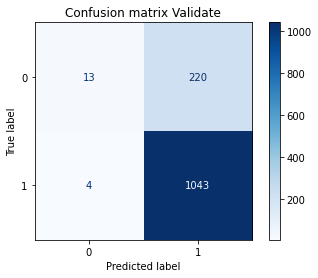

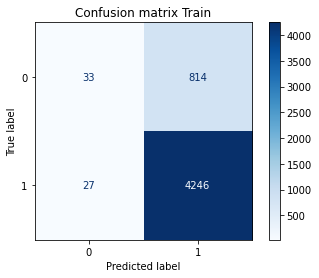

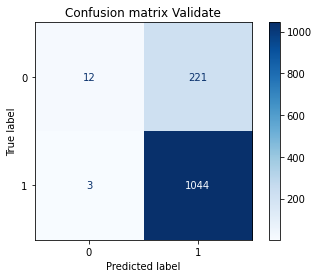

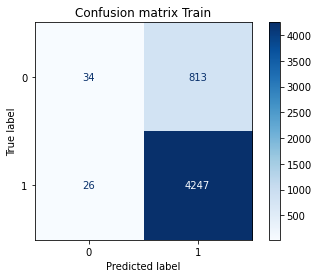

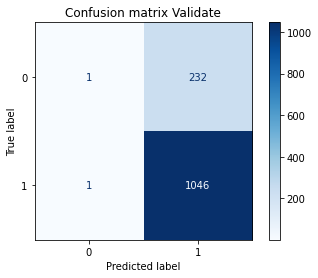

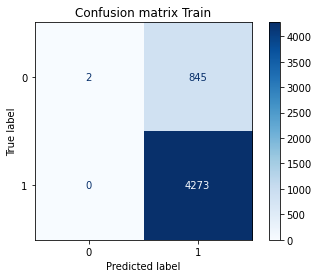

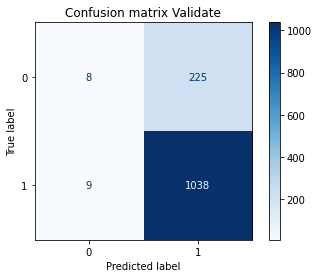

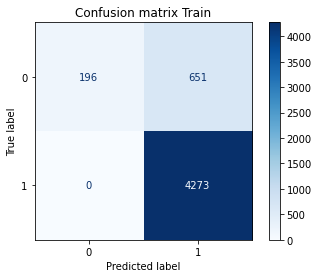

In [52]:
print('Logistic Regression L2 Optimised:')
eval_model(log_reg_l2_optimised, X_train, y_train, X_valid, y_valid)

print('Logistic Regression Elastic Optimised:')
eval_model(log_reg_elastic_optimised, X_train, y_train, X_valid, y_valid)

print('K Nearest Neighbors Optimised:')
eval_model(knn_optimised, X_train, y_train, X_valid, y_valid)

print('Random Forest Optimised:')
eval_model(rfc_optimised, X_train, y_train, X_valid, y_valid)

In [54]:
from src.models.save_predictions import save_predictions

test_data = pd.read_csv('../data/raw/test.csv')
test_data = test_data.loc[:, 'GP':'TOV']

test_data = build(test_data)
test_data = scaler.transform(test_data)

save_predictions('au-ron_week2_rfc.csv', rfc_optimised, test_data)

pd.read_csv('../data/predictions/au-ron_week2_rfc.csv')

Predictions saved to ../data/predictions/au-ron_week2_rfc.csv


,Id,TARGET_5Yrs
0,0.0,0.757207
1,1.0,0.781869
2,2.0,0.896730
3,3.0,0.932866
4,4.0,0.812278
...,...,...
3794,3794.0,0.964644
3795,3795.0,0.806932
3796,3796.0,0.830439
3797,3797.0,0.945831
